# Example 4: Quasi-Monte Carlo

In this example we'll showcase a useful feature of `lintsampler`: Quasi-Monte Carlo sampling (QMC).

[Quasi-Monte Carlo](https://en.wikipedia.org/wiki/Quasi-Monte_Carlo_method) techniques are a class of sampling algorithms which use *low-discrepancy sequences* instead of conventional pseudo-random sampling. These sequences are, by construction, more evenly distributed than pseudo-random samples, so that there is less sampling noise for the same number of samples. Some popular examples of such low discrepancy sequences are the [Sobol sequence](https://en.wikipedia.org/wiki/Sobol_sequence) and the [Halton sequence](https://en.wikipedia.org/wiki/Halton_sequence).

## Python preamble

Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from lintsampler import LintSampler

Matplotlib style file

In [2]:
plt.style.use('figstyle.mplstyle')

## Toy Problem: 2D Gaussian

To demonstrate QMC sampling with `lintsampler`, we'll adopt a simple example of a bivariate Gaussian. For the PDF function to feed to `LintSampler`, we can use the `multivariate_normal` object from `scipy`. 

In [3]:
mean = np.array([0.5, -1.5])
cov = np.array([[1.5, -0.5],
                [-0.5, 0.5]])
pdf = multivariate_normal(mean, cov).pdf

We'll also need a coordinate grid to feed to `LintSampler`:

In [4]:
N_grid = 256
N_s = 2**16
x_edges = np.linspace(-10, 10, N_grid + 1)
y_edges = np.linspace(-10, 10, N_grid + 1)

## Basic Usage

To use QMC sampling with `lintsampler`, simply set the `qmc` flag to `True`. To demonstrate this, we'll take two sets of samples from the PDF, one with QMC and one without.

In [5]:

x0 = LintSampler((x_edges, y_edges), pdf, vectorizedpdf=True).sample(N_s)
x1 = LintSampler((x_edges, y_edges), pdf, vectorizedpdf=True, qmc=True).sample(N_s)

Let's visualise the two sample sets:

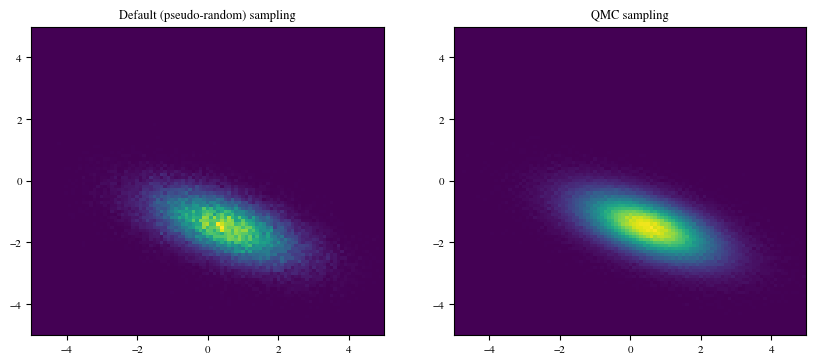

In [6]:
fig = plt.figure(figsize=(10, 4))
ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)
ax0.hist2d(*x0.T, np.linspace(-10, 10, 200));
ax1.hist2d(*x1.T, np.linspace(-10, 10, 200));
ax0.set_title("Default (pseudo-random) sampling")
ax1.set_title("QMC sampling")

for ax in [ax0, ax1]:
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)

The low-discrepancy set on the right clearly has less sampling noise, as promised.

## Custom QMC Engines

The default QMC algorithm adopted under the hood here is the `scipy` implementation of the Sobol sequence: `scipy.stats.qmc.Sobol`, which is a subclass of the base class `scipy.stats.qmc.QMCEngine`.

If we instead want to use a different QMC algorithm (or the Sobol sequence with different parameters), we can instance one of the subclasses of `QMCEngine` and feed that to `lintsampler` via the `qmc_engine` parameter.

One thing the user has to be careful of here is in setting the dimensionality of the custom `QMCEngine`. If sampling from a k-dimensional PDF, the engine should have dimensionality of k+1. This is because, under the hood, the engine draws (N x k+1) uniform samples, uses one column for choosing grid cells and the remainder for lintsampling. In the present problem, we have a bivariate PDF and so need to construct an engine with three dimensions.

Here's an example using Halton sequencing:

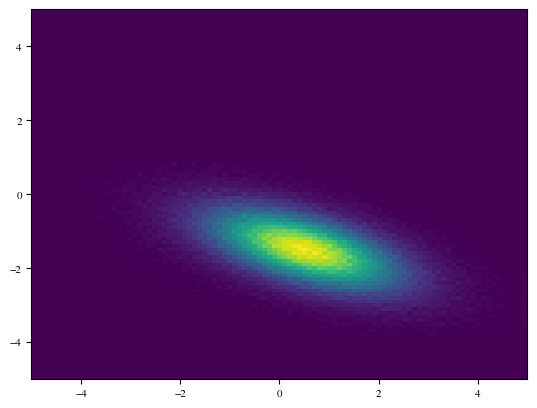

In [8]:
from scipy.stats.qmc import Halton

qmc_engine = Halton(d=3)
x = LintSampler((x_edges, y_edges), pdf, vectorizedpdf=True, qmc=True, qmc_engine=qmc_engine).sample(N_s)

plt.hist2d(*x.T, np.linspace(-10, 10, 200));
plt.xlim(-5, 5)
plt.ylim(-5, 5);

## Beware: sample numbers

Another pitfall to be wary of is that the Sobol sequence (the default QMC algorithm in `lintsampler`) always wants the number of samples to be a power of 2, so a warning is raised if the user requests a number which is not a power of 2. For example:

In [ ]:
LintSampler((x_edges, y_edges), pdf, vectorizedpdf=True, qmc=True).sample(10000);

/localdisk/anaconda/envs/LintsamplerDev/lib/python3.12/site-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


If we wanted to employ QMC sampling but wanted a number of samples which is not a power of 2, we could either:
- Sample more than the desired number then downsample
- Use a different QMC engine (see the example above)